In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, LogisticRegression

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

### Read data

In [2]:
train = pd.read_csv('data/mf_geo_train.csv')
test = pd.read_csv('data/mf_geo_test.csv')

In [3]:
train.head(2)

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206


In [4]:
test.head(2)

,point_id,lon,lat,target
0,F4lXR1cG,37.681242,55.74804,0.0091
1,4LJu4GTf,60.580910,56.79586,0.0091


In [5]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geo_HW")

In [6]:
train['geom'] = train['lat'].map(str) + ',' + train['lon'].map(str)
train['geom'][0]

'55.84863000000001,37.590776'

In [7]:
test['geom'] = test['lat'].map(str) + ',' + test['lon'].map(str)
test['geom'][0]

'55.74804,37.681242'

In [8]:
train['address'] = train['geom'].apply(geolocator.reverse, zoom = 10, exactly_one = True)

In [9]:
test['address'] = test['geom'].apply(geolocator.reverse, zoom = 10, exactly_one = True)

In [10]:
def extract_city(addr):
    addr = str(addr)
    addr.replace("()",'')
    city = addr.split(",")[0]
    return city

In [11]:
train['city'] = train['address'].apply(extract_city)

In [12]:
test['city'] = test['address'].apply(extract_city)

In [13]:
train.head()

,point_id,lon,lat,target,geom,address,city
0,ommNZCUV,37.590776,55.848630,-0.348157,"55.84863000000001,37.590776","(Москва, Центральный федеральный округ, Россия...",Москва
1,nMe2LHPb,37.784210,55.750271,1.294206,"55.750271,37.78421","(Москва, Центральный федеральный округ, Россия...",Москва
2,ZgodVRqB,39.635721,47.213330,-1.039679,"47.21333,39.635721","(Ростов-на-Дону, городской округ Ростов-на-Дон...",Ростов-на-Дону
3,0t2jNYdz,37.704570,55.782020,-1.169339,"55.78202,37.70457","(Москва, Центральный федеральный округ, Россия...",Москва
4,U27W4QJ7,37.643983,55.730188,-0.088837,"55.730188,37.643983","(Москва, Центральный федеральный округ, Россия...",Москва


In [14]:
test.head()

,point_id,lon,lat,target,geom,address,city
0,F4lXR1cG,37.681242,55.748040,0.0091,"55.74804,37.681242","(Москва, Центральный федеральный округ, Россия...",Москва
1,4LJu4GTf,60.580910,56.795860,0.0091,"56.79586,60.58091","(Екатеринбург, городской округ Екатеринбург, С...",Екатеринбург
2,kLuAAN3s,37.598614,55.781357,0.0091,"55.78135699999999,37.59861400000001","(Москва, Центральный федеральный округ, Россия...",Москва
3,OxQHvaNu,37.794051,55.717468,0.0091,"55.717468,37.794051","(Москва, Центральный федеральный округ, Россия...",Москва
4,paQsTa1K,49.213026,55.748290,0.0091,"55.74829,49.213026","(городской округ Казань, Татарстан, Приволжски...",городской округ Казань


In [15]:
train['city'].value_counts()

Москва                         152
Санкт-Петербург                 73
Новосибирск                     23
Екатеринбург                    22
Ростов-на-Дону                  21
городской округ Самара          21
Нижний Новгород                 21
Красноярск                      20
Уфа                             19
городской округ Казань          17
Казань                           8
Самара                           6
Колпино                          4
Зеленоград                       3
городской округ Новосибирск      3
поселение Сосенское              1
поселение Рязановское            1
Кронштадт                        1
Пушкин                           1
поселение Московский             1
Петергоф                         1
Сестрорецк                       1
поселение Воскресенское          1
Щербинка                         1
Красное Село                     1
городской округ Троицк           1
Ломоносов                        1
Name: city, dtype: int64

In [16]:
test['city'].value_counts()

Москва                         39
Санкт-Петербург                20
Новосибирск                     6
Уфа                             5
Ростов-на-Дону                  5
Красноярск                      5
Нижний Новгород                 5
Екатеринбург                    5
Казань                          4
Самара                          4
городской округ Самара          3
городской округ Казань          3
Парголово                       1
Зеленоград                      1
городской округ Новосибирск     1
Name: city, dtype: int64

In [17]:
train.drop('geom', axis=1, inplace=True)
test.drop('geom', axis=1, inplace=True)

In [18]:
train.drop('address', axis=1, inplace=True)
test.drop('address', axis=1, inplace=True)

In [19]:
import requests

In [20]:
lon_min = 28.476563
lat_min = 30.751278
lon_max = 180
lat_max = 79.624056
#28.476563,30.751278,191.601563,79.624056
rus_bbox = lat_min,lon_min,lat_max,lon_max
rus_bbox

(30.751278, 28.476563, 79.624056, 180)

In [21]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json][timeout:60];
(
  node["railway"="station"]["train"="yes"]["network"!="МЦК"]({},{},{},{});
);
out body;
'''.format(*rus_bbox)
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
railways = response.json()

railways_osm = pd.DataFrame(railways['elements'])
railways_osm = railways_osm.join(
    pd.DataFrame([x['tags'] for x in railways['elements']]), lsuffix='_left', rsuffix='_right')

In [22]:
railways_osm.drop('tags', axis=1, inplace=True)

In [23]:
railways_osm = railways_osm[['lat', 'lon', 'name']]

In [24]:
railways_osm

,lat,lon,name
0,58.584182,29.612601,Серебрянка
1,60.039202,30.296460,Озёрная
2,60.104317,30.218622,Левашово
3,55.470884,30.005066,Гарадок
4,55.676429,29.978110,Бычыха
...,...,...,...
7066,36.662848,138.247876,附属中学前
7067,36.678033,138.308666,北須坂
7068,36.704019,138.321962,都住
7069,36.712310,138.349459,桜沢


In [25]:
from geopy import distance
import networkx as nx
import osmnx as ox
ox.config(log_console=True, use_cache=True)
ox.__version__
    

'0.16.2'

In [26]:
train['Railway_nearby'] = 0

In [27]:
from tqdm import tqdm

In [28]:
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    for idx, row2 in railways_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).miles <= 2:
            train.loc[[index], ['Railway_nearby']] = 1
            break

100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [03:46<00:00,  1.88it/s]


In [29]:
train['Railway_nearby'].value_counts()

0    288
1    137
Name: Railway_nearby, dtype: int64

In [30]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json][timeout:60];
(
  node["brand"!="Мегафон"]["shop"="mobile_phone"]({},{},{},{});
);
out body;
'''.format(*rus_bbox)
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
phone_shops = response.json()

phone_shops_osm = pd.DataFrame(phone_shops['elements'])
phone_shops_osm = phone_shops_osm.join(
    pd.DataFrame([x['tags'] for x in phone_shops['elements']]), lsuffix='_left', rsuffix='_right')

In [31]:
phone_shops_osm.drop('tags', axis=1, inplace=True)

In [32]:
phone_shops_osm = phone_shops_osm[['lat', 'lon', 'name']]
phone_shops_osm

,lat,lon,name
0,56.803733,36.026472,Билайн
1,35.580878,140.133744,NaN
2,35.677218,139.777343,ソフトバンクショップ
3,50.255107,28.659117,Vodafone
4,67.580573,63.786791,Евросеть
...,...,...,...
13830,37.832664,68.782564,Tcell
13831,37.830995,68.781452,Телефон бозор аз тарафи гостиница
13832,37.830256,68.780568,Телефон бозор
13833,37.831437,68.781704,Маркази Билайн


In [33]:
phone_shops_osm['name'].value_counts()[:20]

МТС             1176
Связной          966
Евросеть         699
Билайн           685
ドコモショップ          542
ソフトバンクショップ       510
auショップ           483
Мегафон          378
Tele2            332
МегаФон          246
Vodafone         221
Turkcell         212
Теле2            135
ソフトバンク           104
Алло             101
au                90
Київстар          72
ワイモバイル            68
Türk Telekom      43
НА'СВЯЗИ          33
Name: name, dtype: int64

In [34]:
train['phone_shops_nearby'] = 0

In [35]:
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    for idx, row2 in phone_shops_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).miles <= 0.5:
            train.loc[[index], ['phone_shops_nearby']] += 1

100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [09:52<00:00,  1.39s/it]


In [36]:
train['phone_shops_nearby'].value_counts()

0     123
1      51
3      41
4      39
2      37
6      33
7      19
5      16
10     15
8      14
9      14
12      5
14      4
11      3
34      1
13      1
15      1
16      1
18      1
19      1
20      1
25      1
30      1
32      1
35      1
Name: phone_shops_nearby, dtype: int64

In [37]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json][timeout:60];
(
  node["public_transport"="station"]["subway"="yes"]({},{},{},{});
);
out body;
'''.format(*rus_bbox)
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
subways = response.json()

subways_osm = pd.DataFrame(subways['elements'])
subways_osm = subways_osm.join(
    pd.DataFrame([x['tags'] for x in subways['elements']]), lsuffix='_left', rsuffix='_right')

In [38]:
subways_osm.drop('tags', axis=1, inplace=True)

In [39]:
subways_osm = subways_osm[['lat', 'lon', 'name']]
subways_osm

,lat,lon,name
0,55.887177,37.661550,Медведково
1,55.869625,37.664184,Бабушкинская
2,59.965080,30.312690,Петроградская
3,59.955156,30.319457,Горьковская
4,59.950195,30.289149,Спортивная
...,...,...,...
2914,30.760218,103.967435,犀浦
2915,30.761546,103.980820,交大兴业北街
2916,30.751885,103.989809,梓潼宫
2917,35.682560,51.446869,امیر کبیر


In [40]:
train['subways_nearby'] = 0

In [41]:
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    for idx, row2 in subways_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).miles <= 0.5:
            train.loc[[index], ['subways_nearby']] = 1
            break

100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [01:57<00:00,  3.61it/s]


In [42]:
train['subways_nearby'].value_counts()

0    323
1    102
Name: subways_nearby, dtype: int64

In [43]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json][timeout:60];
(
  node["public_transport"="station"]({},{},{},{});
);
out body;
'''.format(*rus_bbox)
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
buses = response.json()

buses_osm = pd.DataFrame(buses['elements'])
buses_osm = buses_osm.join(
    pd.DataFrame([x['tags'] for x in buses['elements']]), lsuffix='_left', rsuffix='_right')

In [44]:
buses_osm = buses_osm[['lat', 'lon', 'name']]
buses_osm

,lat,lon,name
0,59.984775,29.770560,NaN
1,59.988203,30.425010,Пискарёвка
2,59.958182,30.358157,Санкт-Петербург - Финляндский
3,58.584182,29.612601,Серебрянка
4,58.508473,29.479769,Лямцево
...,...,...,...
20994,49.001862,104.004480,NaN
20995,48.997104,104.032313,NaN
20996,39.882549,116.662727,梨园
20997,52.754838,41.385877,Радужный


In [45]:
train['buses_nearby'] = 0

In [46]:
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    for idx, row2 in buses_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).miles <= 0.5:
            train.loc[[index], ['buses_nearby']] += 1

100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [17:02<00:00,  2.40s/it]


In [47]:
train['buses_nearby'].value_counts()

0    279
1    102
2     22
3     11
4      6
7      2
6      2
5      1
Name: buses_nearby, dtype: int64

In [48]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json][timeout:60];
(
  node["amenity"="bureau_de_change"]({},{},{},{});
);
out body;
'''.format(*rus_bbox)
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
changers = response.json()

changers_osm = pd.DataFrame(changers['elements'])
changers_osm = changers_osm.join(
    pd.DataFrame([x['tags'] for x in changers['elements']]), lsuffix='_left', rsuffix='_right')

In [49]:
changers_osm = changers_osm[['lat', 'lon', 'name']]
changers_osm

,lat,lon,name
0,39.885319,32.855927,İnci Döviz
1,47.988686,37.900378,NaN
2,48.005922,37.804784,NaN
3,50.471134,30.479267,NaN
4,45.429329,35.823750,Кредобанк
...,...,...,...
2586,50.514774,30.783083,NaN
2587,33.362322,44.412416,شركة المنامة للصرافة
2588,55.762200,37.568609,NaN
2589,50.242210,28.702602,NaN


In [50]:
train['changers_nearby'] = 0

In [51]:
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    for idx, row2 in changers_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).miles <= 0.5:
            train.loc[[index], ['changers_nearby']] += 1

100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [01:56<00:00,  3.66it/s]


In [52]:
train['changers_nearby'].value_counts()

0     347
1      42
2      15
4       7
3       7
7       3
6       2
13      1
5       1
Name: changers_nearby, dtype: int64

In [53]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json][timeout:60];
(
  node["tourism"="hotel"]({},{},{},{});
);
out body;
'''.format(*rus_bbox)
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
hotels = response.json()

hotels_osm = pd.DataFrame(hotels['elements'])
hotels_osm = hotels_osm.join(
    pd.DataFrame([x['tags'] for x in hotels['elements']]), lsuffix='_left', rsuffix='_right')


In [54]:
hotels_osm = hotels_osm[['lat_left', 'lon_left', 'name']]
hotels_osm

,lat_left,lon_left,name
0,35.037230,34.036392,Golden Coast Hotel
1,35.119714,33.957516,Palm Beach
2,43.889772,28.609651,NOVUM By the Sea
3,32.861755,53.081795,هتل نائین
4,35.887494,51.401110,هتل توچال
...,...,...,...
32651,36.187149,43.972180,Ramada hotel erbil
32652,36.729920,104.791878,凯宾国际大酒店
32653,37.267878,68.143986,Chor Bed Hotel
32654,50.831112,30.914153,Log Hause Savin


In [55]:
train['hotels_nearby'] = 0

In [56]:
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    for idx, row2 in hotels_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat_left'],row2['lon_left'])).miles <= 0.5:
            train.loc[[index], ['hotels_nearby']] += 1

100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [23:54<00:00,  3.37s/it]


In [57]:
train['hotels_nearby'].value_counts()

0      210
1       98
2       37
3       22
4       12
5        8
7        7
6        3
11       3
8        2
12       2
22       2
16       1
9        1
13       1
14       1
149      1
134      1
19       1
27       1
29       1
32       1
34       1
48       1
50       1
70       1
71       1
72       1
79       1
117      1
18       1
Name: hotels_nearby, dtype: int64

### Fit model

In [58]:
from sklearn import preprocessing

In [59]:
le = preprocessing.LabelEncoder()
train['city'] = le.fit_transform(train['city'])
train.head()

,point_id,lon,lat,target,city,Railway_nearby,phone_shops_nearby,subways_nearby,buses_nearby,changers_nearby,hotels_nearby
0,ommNZCUV,37.590776,55.848630,-0.348157,8,0,7,0,1,0,2
1,nMe2LHPb,37.784210,55.750271,1.294206,8,1,8,0,0,0,0
2,ZgodVRqB,39.635721,47.213330,-1.039679,13,0,0,0,0,0,1
3,0t2jNYdz,37.704570,55.782020,-1.169339,8,1,6,1,1,1,3
4,U27W4QJ7,37.643983,55.730188,-0.088837,8,1,12,0,1,0,9


In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop('target', axis=1), train[['target']])
model = LinearRegression().fit(X_train.drop('point_id', axis=1), y_train)

In [61]:
mean_absolute_error(y_valid, model.predict(X_valid.drop('point_id', axis=1)))

0.7740932996421621

### Make submission

In [102]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = model.predict(X_valid.drop('point_id', axis=1))
submission.to_csv('data/my_submission_01.csv', index=False)

Plots

In [21]:
russia_plot = gpd.read_file('data/russia.geojson')

In [22]:
russia_plot

,name,cartodb_id,created_at,updated_at,name_latin,geometry
0,Бурятия,10,2013-12-04T04:23:51+01:00,2013-12-04T08:04:02+01:00,Republic of Buryatia,"POLYGON ((99.23057 52.96319, 99.24053 52.98642..."
1,Карачаево-Черкесская республика,13,2013-12-04T04:23:51+01:00,2013-12-04T08:04:37+01:00,Karachay-Cherkess Republic,"POLYGON ((41.73682 44.47313, 41.79265 44.47052..."
2,Сахалинская область,11,2013-12-04T04:23:51+01:00,2013-12-04T08:06:03+01:00,Sakhalin Oblast,"MULTIPOLYGON (((145.98748 43.36928, 146.01625 ..."
3,Воронежская область,16,2013-12-04T04:23:51+01:00,2013-12-04T08:06:32+01:00,Voronezh Oblast,"POLYGON ((38.29261 51.96594, 38.32064 51.98361..."
4,Томская область,18,2013-12-04T04:23:51+01:00,2013-12-04T08:06:39+01:00,Tomsk Oblast,"POLYGON ((75.10824 58.57625, 75.19930 58.61868..."
...,...,...,...,...,...,...
78,Удмуртская республика,59,2013-12-04T04:23:51+01:00,2013-12-04T08:13:59+01:00,Udmurt Republic,"MULTIPOLYGON (((53.84267 56.61753, 53.88241 56..."
79,Вологодская область,55,2013-12-04T04:23:51+01:00,2013-12-04T08:15:26+01:00,Vologda Oblast,"POLYGON ((34.72236 59.08485, 34.75214 59.09343..."
80,Ингушетия,34,2013-12-04T04:23:51+01:00,2013-12-04T08:16:04+01:00,Republic of Ingushetia,"POLYGON ((44.84761 43.56497, 44.86736 43.55849..."
81,Челябинская область,24,2013-12-04T04:23:51+01:00,2013-12-04T08:16:45+01:00,Chelyabinsk Oblast,"POLYGON ((59.04205 56.16836, 59.03005 56.17331..."


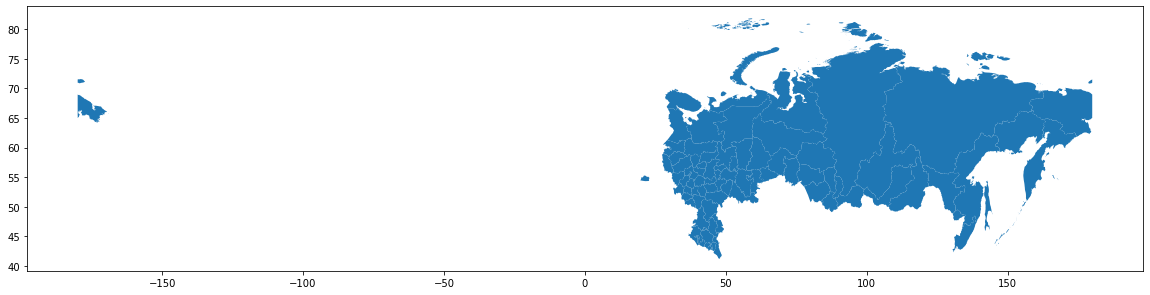

In [23]:
base = russia_plot.plot(figsize=(20, 20))

In [24]:
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon
plot_df = train[['point_id', 'lon', 'lat']]
geometry = [Point(xy) for xy in zip(plot_df.lon, plot_df.lat)]
plot_df = plot_df.drop(['lon', 'lat'], axis=1)
plot_df = gpd.GeoDataFrame(plot_df, crs="EPSG:4326", geometry=geometry)

In [25]:
plot_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   point_id  425 non-null    object  
 1   geometry  425 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 6.8+ KB


<AxesSubplot:>

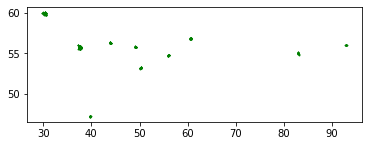

In [32]:
plot_df.plot(marker='*', color='green', markersize=1)

In [35]:
plot_df = plot_df.to_crs(russia_plot.crs)

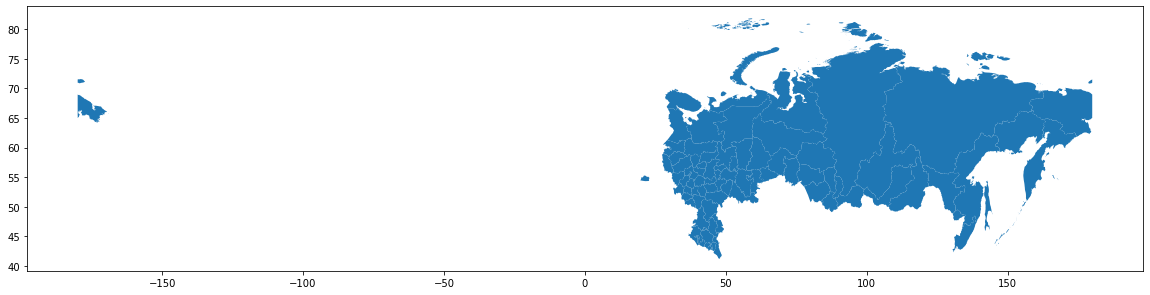

In [36]:
base = russia_plot.plot(figsize=(20, 20))

In [42]:
plot_df

,point_id,geometry
0,ommNZCUV,POINT (37.59078 55.84863)
1,nMe2LHPb,POINT (37.78421 55.75027)
2,ZgodVRqB,POINT (39.63572 47.21333)
3,0t2jNYdz,POINT (37.70457 55.78202)
4,U27W4QJ7,POINT (37.64398 55.73019)
...,...,...
420,AA8hN7bJ,POINT (37.62877 55.74066)
421,uNw6t6xk,POINT (37.58682 55.79423)
422,Ap42ei8k,POINT (37.67879 55.77291)
423,rn9A8r62,POINT (37.75213 55.61964)


In [38]:
%matplotlib inline

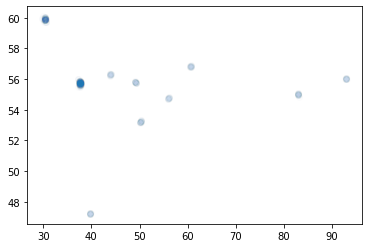

In [43]:
import matplotlib.pyplot as plt
plt.scatter(train.lon, train.lat, alpha=.01)

In [48]:
plot_df.plot(ax=base, marker='o', color='red', markersize=5, figsize=(20,20))

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

In [ ]:
russia_plot = russia_plot.merge()

In [50]:
!pip install folium

In [62]:
import folium


m = folium.Map(location=[55.741209, 37.608771])

In [63]:
m

In [65]:
tooltip = 'Click me!'

for index, row in train.iterrows():
    folium.Marker([row.lat, row.lon], popup='<i>' + row.point_id + '</i>', tooltip=tooltip).add_to(m)

m

In [79]:
moscow_df = train[train['city'] == 'Москва']
moscow_df

,point_id,lon,lat,target,geom,address,city
0,ommNZCUV,37.590776,55.848630,-0.348157,"55.84863000000001,37.590776","(Москва, Центральный федеральный округ, Россия...",Москва
1,nMe2LHPb,37.784210,55.750271,1.294206,"55.750271,37.78421","(Москва, Центральный федеральный округ, Россия...",Москва
3,0t2jNYdz,37.704570,55.782020,-1.169339,"55.78202,37.70457","(Москва, Центральный федеральный округ, Россия...",Москва
4,U27W4QJ7,37.643983,55.730188,-0.088837,"55.730188,37.643983","(Москва, Центральный федеральный округ, Россия...",Москва
7,CO76tdVs,37.444304,55.850511,0.213704,"55.850511,37.444304","(Москва, Центральный федеральный округ, Россия...",Москва
...,...,...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,"55.740664,37.628765","(Москва, Центральный федеральный округ, Россия...",Москва
421,uNw6t6xk,37.586825,55.794233,-0.002397,"55.794233,37.586825","(Москва, Центральный федеральный округ, Россия...",Москва
422,Ap42ei8k,37.678790,55.772910,-0.910019,"55.77291,37.67879","(Москва, Центральный федеральный округ, Россия...",Москва
423,rn9A8r62,37.752130,55.619640,-0.326547,"55.61964,37.75213","(Москва, Центральный федеральный округ, Россия...",Москва


In [83]:
moscow_df['address'] = moscow_df['geom'].apply(geolocator.reverse)

In [84]:
moscow_df

,point_id,lon,lat,target,geom,address,city
0,ommNZCUV,37.590776,55.848630,-0.348157,"55.84863000000001,37.590776","(6А, Сигнальный проезд, район Отрадное, Москва...",Москва
1,nMe2LHPb,37.784210,55.750271,1.294206,"55.750271,37.78421","(38/18, 2-я Владимирская улица, Новогиреево, р...",Москва
3,0t2jNYdz,37.704570,55.782020,-1.169339,"55.78202,37.70457","(Торговый центр ""Серебряный Дом"", 16, Большая ...",Москва
4,U27W4QJ7,37.643983,55.730188,-0.088837,"55.730188,37.643983","(5, Кожевническая улица, район Замоскворечье, ...",Москва
7,CO76tdVs,37.444304,55.850511,0.213704,"55.850511,37.444304","(Торгово-развлекательный центр ""Калейдоскоп"", ...",Москва
...,...,...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,"55.740664,37.628765","(31 с3, Пятницкая улица, Садовники, район Замо...",Москва
421,uNw6t6xk,37.586825,55.794233,-0.002397,"55.794233,37.586825","(2/18, Бутырская улица, Бутырский район, Москв...",Москва
422,Ap42ei8k,37.678790,55.772910,-0.910019,"55.77291,37.67879","(33/2 с1, Бауманская улица, Бауманка, Басманны...",Москва
423,rn9A8r62,37.752130,55.619640,-0.326547,"55.61964,37.75213","(6, Кустанайская улица, Зябликово, район Зябли...",Москва


In [91]:
def extract_district(addr):
    addr = str(addr)
    addr.replace("()",'')
    laddr = addr.split(",")
    for el in laddr:
        if el.find('район') != -1:      
            return el

In [92]:
moscow_df['district'] = moscow_df['address'].apply(extract_district)

In [119]:
moscow_df

,point_id,lon,lat,target,geom,address,city,district
0,ommNZCUV,37.590776,55.848630,-0.348157,"55.84863000000001,37.590776","(6А, Сигнальный проезд, район Отрадное, Москва...",Москва,район Отрадное
1,nMe2LHPb,37.784210,55.750271,1.294206,"55.750271,37.78421","(38/18, 2-я Владимирская улица, Новогиреево, р...",Москва,район Новогиреево
3,0t2jNYdz,37.704570,55.782020,-1.169339,"55.78202,37.70457","(Торговый центр ""Серебряный Дом"", 16, Большая ...",Москва,район Соколиная Гора
4,U27W4QJ7,37.643983,55.730188,-0.088837,"55.730188,37.643983","(5, Кожевническая улица, район Замоскворечье, ...",Москва,район Замоскворечье
7,CO76tdVs,37.444304,55.850511,0.213704,"55.850511,37.444304","(Торгово-развлекательный центр ""Калейдоскоп"", ...",Москва,район Южное Тушино
...,...,...,...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,"55.740664,37.628765","(31 с3, Пятницкая улица, Садовники, район Замо...",Москва,район Замоскворечье
421,uNw6t6xk,37.586825,55.794233,-0.002397,"55.794233,37.586825","(2/18, Бутырская улица, Бутырский район, Москв...",Москва,Бутырский район
422,Ap42ei8k,37.678790,55.772910,-0.910019,"55.77291,37.67879","(33/2 с1, Бауманская улица, Бауманка, Басманны...",Москва,Басманный район
423,rn9A8r62,37.752130,55.619640,-0.326547,"55.61964,37.75213","(6, Кустанайская улица, Зябликово, район Зябли...",Москва,район Зябликово


In [105]:
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data'
state_geo = f'{url}/moscow.geojson'


m3 = folium.Map(location=[55.741209, 37.608771], zoom_start=10)

folium.GeoJson(
    state_geo,
    name='geojson'
).add_to(m3)

folium.LayerControl().add_to(m3)


m3

In [118]:
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data'
state_geo = f'{url}/moscow.geojson'

m2 = folium.Map(location=[55.741209, 37.608771], zoom_start=10)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=moscow_df,
    columns=['district', 'target'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Target value'
).add_to(m2)

folium.LayerControl().add_to(m2)

m2